# Puzzle solving
## Matej Kopecky

In [357]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import permutations, product
from skimage import color
import cv2

In [358]:
from utils import Segmentation
segmenter = Segmentation()

TOP = "top"
LEFT = "left"
RIGHT = "right"
BOTTOM = "bottom"

In [359]:
class SmallSquare:
    def __init__(self, img:np.ndarray, position=(0,0), rotation_cw=0) -> None:
        self.img = img

        self.get_edge_pixels()

        self.position = position
        self.rotation_cw = rotation_cw

    def get_edge_pixels(self):
        
        if len(self.img.shape) == 3:
            top = self.img[0,:,:]
            bottom = self.img[-1,:,:]
            left = self.img[:,0,:]
            right = self.img[:,-1,:]
        elif len(self.img.shape) == 2:
            top = self.img[0,:]
            bottom = self.img[-1,:]
            left = self.img[:,0]
            right = self.img[:,-1]

        self.edges = {TOP:top, BOTTOM:bottom, LEFT:left, RIGHT:right}

In [360]:
class Configuration:
    def __init__(self, squares:dict, shape:tuple, positions:dict=None, rotations:dict=None):
        
        assert shape[0]*shape[1] == len(squares)

        self.squares = squares
        self.shape = shape
        self.positions = positions
        self.rotations = rotations

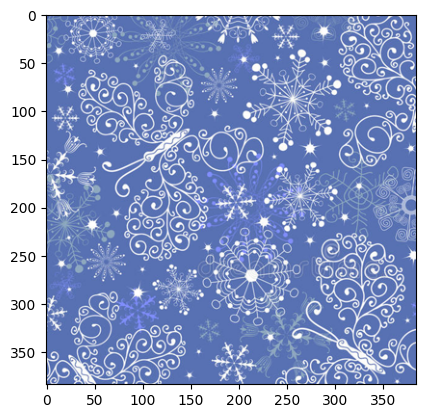

In [361]:
input_img = "00_00"
img = segmenter.load_input_image_(input_img, folder="train2_solutions", flag='solution')
plt.imshow(img)

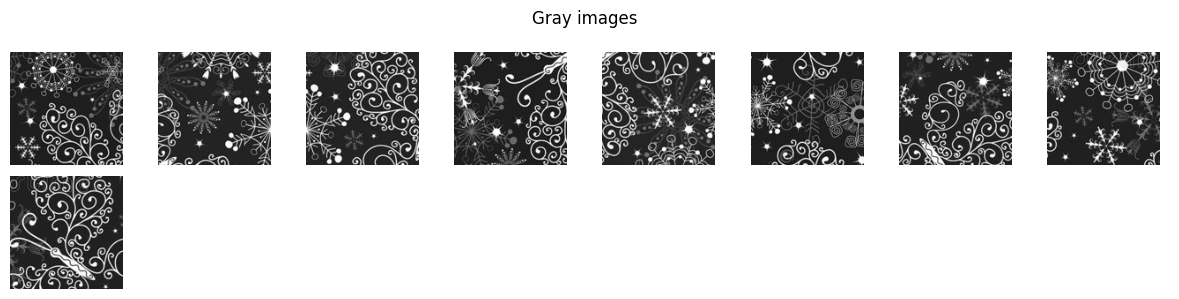

In [362]:
img = segmenter.load_input_image_(input_img, folder="train2_solutions", flag='solution')

def split_image(img, size=128):
    if img.shape[0] % size != 0 or img.shape[1] % size != 0:
        raise ValueError(f"Image size is wrong for piece size {size}x{size}.")
    
    piece_vert = img.shape[0]//size
    piece_hori = img.shape[1]//size

    pieces = []
    for i in range(piece_vert):
        for j in range(piece_hori):
            new_piece = img[i*size:(i+1)*size, j*size:(j+1)*size,:]
            pieces.append(new_piece)

    return pieces
    
pieces = split_image(img)
pieces_gray = [cv2.cvtColor(p, cv2.COLOR_BGR2GRAY) for p in pieces]
pieces_blur = [cv2.GaussianBlur(p,(3,3),0) for p in pieces_gray]
pieces_th = [cv2.threshold(p,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1] for p in pieces_blur]

Segmentation.plot_images(pieces_gray, title="Gray images", cmap="gray")

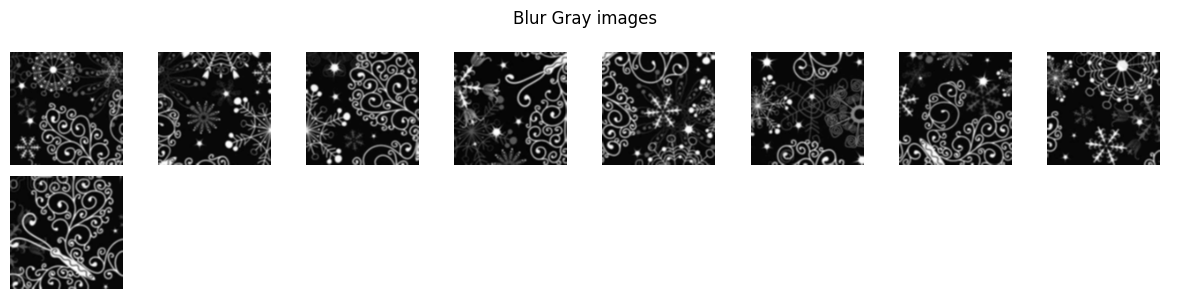

In [363]:
Segmentation.plot_images(pieces_blur, title="Blur Gray images", cmap="gray")

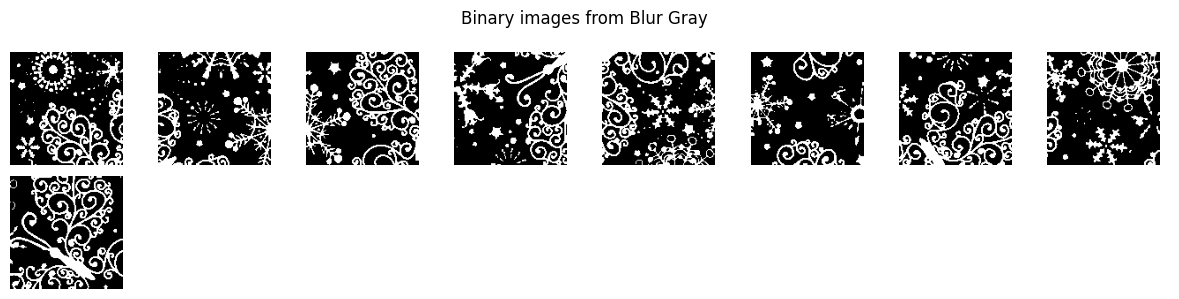

In [364]:
Segmentation.plot_images(pieces_th, title="Binary images from Blur Gray", cmap="gray")

In [365]:
sq0 = SmallSquare(pieces[0], position=(0,0))
sq1 = SmallSquare(pieces[1], position=(0,1))
sq3 = SmallSquare(pieces[3], position=(1,0))
sq4 = SmallSquare(pieces[4], position=(1,1))
four_squares = [sq0, sq1, sq3, sq4]

In [366]:
def plot_images_2by2(image_list:list, perm:list):

    assert len(image_list) == len(perm)

    num = int(np.sqrt(len(image_list)))

    fig, axes = plt.subplots(num, num)
    #fig = plt.figure(figsize=(4, 4))
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
    for i in range(len(image_list)): 
        axes[perm[i]].imshow(image_list[i])
        axes[perm[i]].axis('off')
        axes[perm[i]].set_aspect(1)
    plt.show()

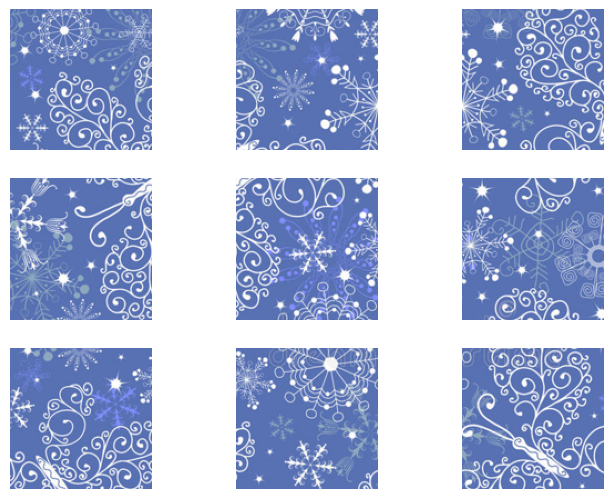

In [367]:
perm = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
plot_images_2by2(pieces, perm)

In [368]:
def edge_difference(edge0:np.ndarray, edge1:np.ndarray):
    diff = edge0.astype(np.float_) - edge1.astype(np.float_)
    abs_diff = np.abs(diff)
    squared = np.power(abs_diff, 2)
    sum_squared = np.sum(squared)
    #weighted_sum = np.sum(2*squared[:,0] + 4*squared[:,1] + 3*squared[:,2])
    edge_diff = np.sqrt(sum_squared)
    return edge_diff

In [369]:
def edge_mse(edge0:np.ndarray, edge1:np.ndarray):
    diff = edge0.astype(np.float_) - edge1.astype(np.float_)
    squared = np.power(diff, 2)
    #weighted_sum = np.sum(2*squared[:,0] + 4*squared[:,1] + 3*squared[:,2])
    sq_mean = np.mean(squared)
    #print(sq_mean)
    return sq_mean

In [370]:
def edges_delta_e(edge0:np.ndarray, edge1:np.ndarray):
    lab_0 = color.rgb2lab(edge0)
    lab_1 = color.rgb2lab(edge1)
    delta_e = np.linalg.norm(lab_0 - lab_1, axis=1)
    average_distance = np.mean(delta_e)
    return average_distance

In [371]:
def calculate_configuration_cost(config: Configuration):
    cost = 0
    for i in range(config.shape[0]):
        for j in range(config.shape[1]):
            square = config.squares[(i, j)]
            if i < config.shape[0]-1:
                edge0 = square.edges[RIGHT]
                edge1 = config.squares[(i + 1, j)].edges[LEFT]
                cost += edge_difference(edge0=edge0, edge1=edge1)
                #cost += edge_mse(edge0=edge0, edge1=edge1)
                #cost += edges_delta_e(edge0,edge1)
                #print(cost)
            if j < config.shape[1]-1:
                edge0 = square.edges[BOTTOM]
                edge1 = config.squares[(i, j + 1)].edges[TOP]
                cost += edge_difference(edge0=edge0, edge1=edge1)
                #cost += edge_mse(edge0=edge0, edge1=edge1)
                #cost += edges_delta_e(edge0, edge1)
                #print(cost)
    return cost

In [372]:
### 9 squares
positions9 = list(product([0,1,2], repeat=2))
perm_list9 = list(permutations(positions9))
shape=(3,3)

### 4 squares
positions4 = list(product([0,1], repeat=2))
perm_list4 = list(permutations(positions4))
shape4 = (2,2)
print(len(perm_list4))

24


In [373]:
nine_squares = []
for i in range(len(pieces)):
    square = SmallSquare(pieces[i])
    nine_squares.append(square)

In [374]:
four_gray = [SmallSquare(g) for g in pieces_gray[:4]]
four_th = [SmallSquare(th) for th in pieces_th[:4]]

In [375]:
to_build = four_th

configurations = []
for perm in perm_list4:
    squares = {}
    for i in range(len(to_build)):
        squares[perm[i]] = to_build[i]
    config = Configuration(squares, shape4)
    configurations.append(config)
    
costs = []
for i in range(len(configurations)):
    config = configurations[i]
    cost = calculate_configuration_cost(config)
    costs.append(cost)
    print(f"{i} : {cost}")

min_i = np.argmin(costs)
min_cost = min(costs)
min_perm = perm_list4[min_i]
print(f"Min {min_i} : {min_cost}")
print(f"Permutation: {min_perm}")

0 : 7036.044413188978
1 : 6366.425319061871
2 : 6891.551997301927
3 : 7416.189938380188
4 : 6586.083085428695
5 : 6999.0016362356
6 : 6993.741041720033
7 : 7100.58980857206
8 : 7078.032076538226
9 : 7537.6456001482875
10 : 6662.252071601179
11 : 6752.596995284319
12 : 7436.23824147521
13 : 7555.794643083531
14 : 6625.035127667465
15 : 6849.691634281864
16 : 7191.336912177731
17 : 7034.017184108913
18 : 7163.679091580153
19 : 7341.640625391393
20 : 6772.645298379341
21 : 7326.494717382781
22 : 7661.332906767074
23 : 7255.8823075608125
Min 1 : 6366.425319061871
Permutation: ((0, 0), (0, 1), (1, 1), (1, 0))


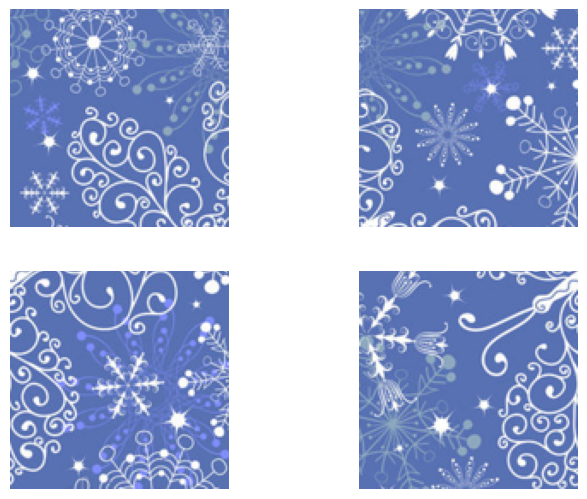

In [376]:
#plt.imshow(nine_squares[0].img)
#min_perm = perm_list4[0]
sqr_plot = [sq.img for sq in four_squares]
plot_images_2by2(sqr_plot, min_perm)

In [377]:
images = sqr_plot
# Calculate the dimensions of the final image
image_width, image_height, image_depth = images[0].shape
final_width = image_width * 3
final_height = image_height * 3

print(final_width)
print(final_height)

384
384


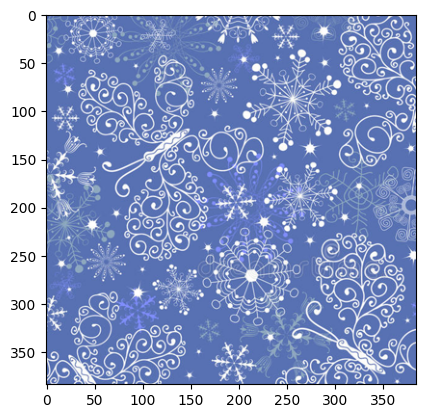

In [378]:
plt.imshow(img)

In [379]:
from PIL import Image
# Create a new blank image to paste the other images onto
final_image = Image.new('RGB', (final_width, final_height))

# Paste each image onto the final image according to the permutation
for index, pos in enumerate(min_perm):
    x_offset = pos[1] * image_width
    y_offset = pos[0] * image_height
    img_to_paste = Image.fromarray(images[index])
    final_image.paste(img_to_paste, (x_offset, y_offset))

# Save or display the final image
#final_image.save("final_image.jpg")
final_image.show()
#display(final_image)

In [380]:
def get_edge_pixels(img):
    top = img[0,:]
    bottom = img[-1,:]
    left = img[:,0]
    right = img[:,-1]

    edges = np.array([top, right, bottom, left])

    return edges

edges = [get_edge_pixels(pieces[i]) for i in range(2)]

In [381]:
def find_two_best_edges(edges):
    piece_0 = edges[0]
    piece_1 = edges[1]
    last_mse = float('inf')
    indexes = (-1, -1)
    for i in range(piece_0.shape[0]):
        for j in range(piece_1.shape[0]):
           squared_diff = (piece_0[i] - piece_1[j]) ** 2
           mse = np.mean(squared_diff)
           print(f"{(i,j)}, mse: {mse:.2f}")
           if mse < last_mse:
               last_mse = mse
               indexes = (i,j)
    return indexes

indexes = find_two_best_edges(edges)
print(indexes)
               

(0, 0), mse: 78.31
(0, 1), mse: 84.77
(0, 2), mse: 83.63
(0, 3), mse: 87.24
(1, 0), mse: 84.99
(1, 1), mse: 85.52
(1, 2), mse: 83.73
(1, 3), mse: 69.56
(2, 0), mse: 77.15
(2, 1), mse: 87.02
(2, 2), mse: 88.71
(2, 3), mse: 76.94
(3, 0), mse: 74.65
(3, 1), mse: 64.89
(3, 2), mse: 61.43
(3, 3), mse: 68.20
(3, 2)


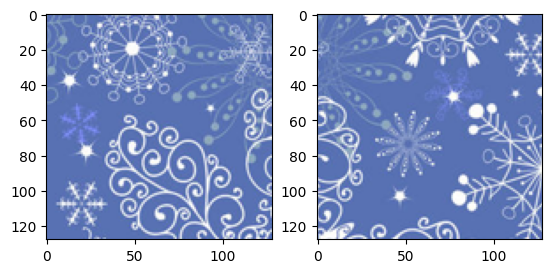

In [382]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(pieces[0])
axes[1].imshow(pieces[1])

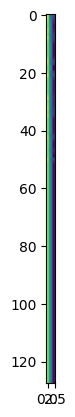

In [383]:
from skimage import io, color
lab = color.rgb2lab(edges[0][3])
plt.imshow(lab)

In [384]:
def calculate_lab_distance(edges):
    piece_0 = edges[0]
    piece_1 = edges[1]
    last_distance = float('inf')
    edge_indexes = (-1, -1)
    for i in range(piece_0.shape[0]):
        for j in range(piece_1.shape[0]):
           lab_0 = color.rgb2lab(piece_0[i])
           lab_1 = color.rgb2lab(piece_1[j])
           delta_e = np.linalg.norm(lab_0 - lab_1, axis=1)
           average_distance = np.mean(delta_e)
           print(f"{(i,j)}, mse: {average_distance:.2f}")
           if average_distance < last_distance:
               last_distance = average_distance
               edge_indexes = (i,j)
    return edge_indexes

edge_indexes = calculate_lab_distance(edges)
print(edge_indexes)

(0, 0), mse: 21.62
(0, 1), mse: 20.35
(0, 2), mse: 23.28
(0, 3), mse: 18.16
(1, 0), mse: 23.02
(1, 1), mse: 24.12
(1, 2), mse: 25.06
(1, 3), mse: 10.84
(2, 0), mse: 20.01
(2, 1), mse: 23.80
(2, 2), mse: 25.12
(2, 3), mse: 17.93
(3, 0), mse: 20.88
(3, 1), mse: 18.07
(3, 2), mse: 17.87
(3, 3), mse: 15.23
(1, 3)


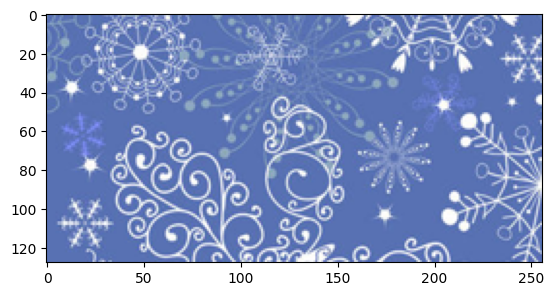

In [385]:
def put_together(pieces, edge_indexes):
    index1 = edge_indexes[0]
    index2 = edge_indexes[1]

    image1 = pieces[0]
    image2 = pieces[1]

    # Rotate the second image if necessary
    '''
    if index2 == 1:
        image2 = imutils.rotate(image2, angle=-90)
    elif index2 == 2:
        image2 = imutils.rotate(image2, angle=180)
    elif index2 == 3:
        image2 = imutils.rotate(image2, angle=90)
    '''
    # Combine the images based on the indexes
    if index1 == 0:
        combined = np.vstack((image2, image1))
    elif index1 == 1:
        combined = np.hstack((image1, image2))
    elif index1 == 2:
        combined = np.vstack((image1, image2))
    elif index1 == 3:
        combined = np.hstack((image2, image1))

    if index1 == 1 and index2 == 3:
        combined = np.hstack((image1, image2))
    elif index1 == 3 and index2 == 1:
        combined = np.hstack((image2, image1))


    return combined

combined = put_together(pieces, edge_indexes)
plt.imshow(combined)

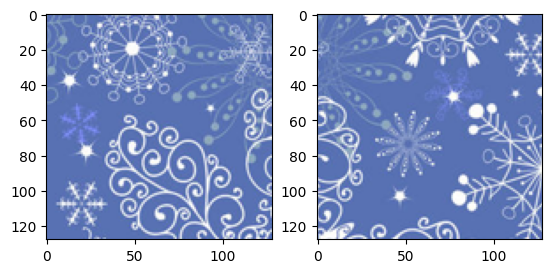

In [386]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(pieces[0])
axes[1].imshow(pieces[1])